# Procedural generation

A notebook for poking at procedural generation techniques.

**TODO:**
- voronoi cells
- wave function collapse
- biome mapping
- varied tunnels

## Setup

This section sets things used later by the generators we use later in the notebook.

### Imports

* `pillow` is used for image generation.
* `opensimplex` is used for generating noise.

In [ ]:
# imports

import copy
import dataclasses
import math
import random
import typing

import opensimplex
import PIL


### Constants

Some constants used in the generators.

* `WIDTH` and `HEIGHT` are the dimensions of the map.
* `AIR` AND `WALL` are the tile values for air and wall tiles.

In [ ]:
# constants

WIDTH = 200
HEIGHT = 200

AIR = 1
WALL = 0

BIOME_VOID = 0
BIOME_FOREST = 1
BIOME_JUNGLE = 2
BIOME_SAVANNA = 3
BIOME_PLAINS = 4
BIOME_TAIGA = 5
BIOME_TUNDRA = 6
BIOME_DESERT = 7
BIOME_MOUNTAIN = 8
BIOME_SWAMP = 9
BIOME_BEACH = 10
BIOME_OCEAN = 11
BIOME_CAVE = 12
BIOME_DUNGEON = 13
BIOME_MINE = 14
BIOME_RUINS = 15
BIOME_CRYPT = 16
BIOME_CATACOMBS = 17
BIOME_LABYRINTH = 18
BIOME_FORTRESS = 19


### Types

The following are some simple types used in this notebook.

In [ ]:
type Map = list[list[int]]

type FloatMap = list[list[float]]

type Point = tuple[int, int]  # x, y

type Rect = tuple[int, int, int, int]  # x, y, width, height


#### Brush

Drawing parameters.

In [ ]:
@dataclasses.dataclass
class Brush:
    size: int = 1
    value: int = AIR
    symmetry: typing.Literal["none", "horizontal", "vertical", "both"] = "none"


#### Context

Contains information related to dungeon generation.

In [ ]:
@dataclasses.dataclass
class Context:
    seed: int
    data: Map
    x: int
    y: int
    width: int
    height: int
    rng: random.Random
    frames: list[Map] = dataclasses.field(default_factory=list)

    def draw(self, x: int, y: int, brush: Brush) -> int:
        ox = x - brush.size // 2
        oy = y - brush.size // 2

        result = 0

        for ix, iy in self.points_for(ox, oy, brush.size, brush.size):

            if not self.contains(ix, iy):
                continue

            if self.data[self.y + iy][self.x + ix] != brush.value:
                result += 1

            self.data[self.y + iy][self.x + ix] = brush.value

            mx = self.x + self.width - ix - 1
            my = self.y + self.height - iy - 1

            if brush.symmetry == "horizontal" or brush.symmetry == "both":
                if self.data[self.y + iy][self.x + mx] != brush.value:
                    result += 1

                self.data[self.y + iy][self.x + mx] = brush.value

            if brush.symmetry == "vertical" or brush.symmetry == "both":
                if self.data[self.y + my][self.x + ix] != brush.value:
                    result += 1

                self.data[self.y + my][self.x + ix] = brush.value

            if brush.symmetry == "both":
                if self.data[self.y + my][self.x + mx] != brush.value:
                    result += 1

                self.data[self.y + my][self.x + mx] = brush.value

        return result

    def contains(self, x: int, y: int) -> bool:
        return x >= 0 and x < self.width and y >= 0 and y < self.height

    def constrain(self, x: int, y: int) -> tuple[int, int]:
        return max(0, min(self.width - 1, x)), max(0, min(self.height - 1, y))

    def random_neighbour_for(self, x: int, y: int) -> tuple[int, int]:
        match self.rng.randint(0, 3):
            case 0:
                x += 1
            case 1:
                x -= 1
            case 2:
                y += 1
            case 3:
                y -= 1

        return x, y

    def neighbours_for(self, x: int, y: int, value: int, default: int | None = None) -> int:
        default = default if default is not None else value

        return sum(
            self.value_for(x + dx, y + dy, default) == value
            for dx in range(-1, 2)
            for dy in range(-1, 2)
        )

    def value_for(self, x: int, y: int, default=None) -> int | None:
        if not self.contains(x, y):
            return default

        return self.data[self.y + y][self.x + x]

    def to_global(self, x: int, y: int) -> tuple[int, int]:
        return x + self.x, y + self.y

    def count_of(
        self,
        value: int = WALL
    ) -> int:
        return sum(
            1
            for y in range(self.y, self.y + self.height)
            for x in range(self.x, self.x + self.width)
            if self.data[y][x] == value
        )

    def random_point(self) -> tuple[int, int]:
        return self.rng.randint(0, self.width - 1), self.rng.randint(0, self.height - 1)

    def size(self) -> int:
        return self.width * self.height

    def copy(self) -> typing.Self:
        return Context(
            seed=self.seed,
            data=copy.deepcopy(self.data),
            x=self.x,
            y=self.y,
            width=self.width,
            height=self.height,
            rng=self.rng,
        )

    def subcontext(self, x: int, y: int, width: int, height: int) -> typing.Self:
        x = min(x, self.width - self.x)
        y = min(y, self.height - self.y)

        width = min(width, self.width - self.x - x)
        height = min(height, self.height - self.y - y)

        return Context(
            seed=self.seed,
            data=self.data,
            x=self.x + x,
            y=self.y + y,
            width=width,
            height=height,
            rng=self.rng,
        )

    def points(self) -> typing.Generator[tuple[int, int], None, None]:
        return self.points_for(0, 0, self.width, self.height)

    def points_for(
        self,
        x: int,
        y: int,
        width: int,
        height: int
    ) -> typing.Generator[tuple[int, int], None, None]:
        for iy in range(y, y + height):
            for ix in range(x, x + width):
                yield ix, iy


#### Generator

Generators are the main type used in this notebook. They are functions that when given
a region of a map, will populate it with `WALL` and `AIR` tiles.

In [ ]:
class Generator(typing.Protocol):
    def __call__(
        self,
        context: Context
    ) -> None:
        """
        Generator

        :param context: map context
        """


#### Room generators

Room generators are functions that return a set of rectangles representing rooms on
a map. They are used in room based generation.

In [ ]:

class RoomGenerator(typing.Protocol):
    def __call__(
        self,
        context: Context
    ) -> list[Rect]:
        """
        Room Generator

        :param context: map context

        :return: list of room bounding boxes
        """


#### Edge generators

Edge generations are functions that return a set of edges corresponding to the indexes
of the passed rooms, they represent the connections between rooms.

In [ ]:

class EdgeGenerator(typing.Protocol):
    def __call__(
        self,
        rooms: list[Rect],
        context: Context
    ) -> list[tuple[int, int]]:
        """
        Edge generator

        :param rooms: list of room bounding boxes
        :param context: map context

        :return: list of connections between rooms
        """


#### Tunnel generator

Tunnel generators are functions that will add air and wall tiles to the map to form 
tunnels between the center points of two rooms.

They generate the tunnels for the edges generated by the edge generators.

In [ ]:

class TunnelGenerator(typing.Protocol):
    def __call__(
        self,
        context: Context,
        x1: int,
        y1: int,
        x2: int,
        y2: int,
    ) -> None:
        """
        Tunnel generator

        :param context: map context
        :param x1: x coordinate of the first room
        :param y1: y coordinate of the first room
        :param x2: x coordinate of the second room
        :param y2: y coordinate of the second room
        """


### Rendering

This function renders a map, it takes a two dimensional list of tile values and a
color map and renders the map with matplotlib.


In [ ]:
# render output

import PIL.ImageDraw
import PIL.ImageFont

DEFAULT_PALETTE = [
    0, 0, 0,  # black
    255, 255, 255,  # white
]

GRAYSCALE_PALETTE = [
    v for v in range(0, 256) for _ in range(3)
]

BIOME_PALETTE = [
    0, 0, 0,  # BIOME_VOID - Black
    34, 139, 34,  # BIOME_FOREST - Dark Green
    0, 128, 0,  # BIOME_JUNGLE - Vibrant Green
    189, 183, 107,  # BIOME_SAVANNA - Light Yellowish Green
    124, 252, 0,  # BIOME_PLAINS - Light Green
    0, 128, 64,  # BIOME_TAIGA - Pine Green
    176, 224, 230,  # BIOME_TUNDRA - Icy Blue
    237, 201, 175,  # BIOME_DESERT - Sandy Beige
    139, 137, 137,  # BIOME_MOUNTAIN - Rocky Grey
    85, 107, 47,  # BIOME_SWAMP - Murky Green
    255, 228, 181,  # BIOME_BEACH - Light Sand
    0, 0, 255,  # BIOME_OCEAN - Deep Blue
    64, 64, 64,  # BIOME_CAVE - Dark Grey
    75, 0, 130,  # BIOME_DUNGEON - Dark Purple
    169, 169, 169,  # BIOME_MINE - Steel Grey
    139, 69, 19,  # BIOME_RUINS - Faded Brown
    128, 0, 32,  # BIOME_CRYPT - Dark Burgundy
    139, 105, 20,  # BIOME_CATACOMBS - Dusty Brown
    0, 0, 139,  # BIOME_LABYRINTH - Dark Blue
    139, 0, 0,  # BIOME_FORTRESS - Dark Red
]

FONT = PIL.ImageFont.truetype("./inter.ttf", size=14)

FONT.set_variation_by_name("SemiBold")


def normalize_floats(data: FloatMap) -> FloatMap:
    min_data = min(value for row in data for value in row)
    max_data = max(value for row in data for value in row)

    if min_data == max_data:
        min_data = 0
        max_data = 1

    return [
        [(value - min_data) / (max_data - min_data) for value in row]
        for row in data
    ]


def to_map(
    data: FloatMap,
    palette_size: int = 255,
) -> Map:
    return [
        [round(value * palette_size) for value in row]
        for row in normalize_floats(data)
    ]


def wordwrap(
    text: str,
    width: int,
    spacing: int,
    font: PIL.ImageFont.ImageFont,
) -> tuple[str, tuple[int, int, int, int]]:
    box = [0, 0, 0, 0]
    lines = []

    line = []

    for word in text.split(" "):
        if font.getlength(" ".join([*line, word])) < width:
            line.append(word)
        else:
            lines.append(" ".join(line))
            bbox = font.getbbox(lines[-1])

            box[2] = max(box[2], bbox[2])
            box[3] += bbox[3] - bbox[1] + spacing

            line = [word]

    if line:
        lines.append(" ".join(line))

        bbox = font.getbbox(lines[-1])

        box[2] = max(box[2], bbox[2])
        box[3] += bbox[3] - bbox[1] + spacing

    return "\n".join(lines), box


def render_data(
    data: Map,
    width: int,
    height: int,
    title: str | None = None,
    palette: list[int] = DEFAULT_PALETTE,
    font: PIL.ImageFont.ImageFont = FONT
) -> None:
    scale = 2
    offset = 10
    border = 2
    bottom = 0

    if title is not None:
        lines, box = wordwrap(title, width * scale, 4, font)
        bottom = box[3] - box[1] + offset
    else:
        lines = ""

    buffer = bytes(x for y in data for x in y)

    image = PIL.Image.frombuffer(data=buffer, mode="P", size=(width, height))
    image.putpalette(palette)
    image = image.resize(
        size=(image.size[0] * scale, image.size[1] * scale),
        resample=PIL.Image.NEAREST
    )

    figure = PIL.Image.new(
        mode="RGB",
        size=(
            image.size[0] + (offset + border) * 2,
            image.size[1] + (offset + border) * 2 + bottom,
        ),
        color=(255, 255, 255)
    )

    draw = PIL.ImageDraw.Draw(figure)

    draw.rectangle(
        xy=(
            offset,
            offset,
            figure.size[0] - offset - 1,
            figure.size[1] - offset - 1 - bottom,
        ),
        fill=(0, 0, 0),
    )

    figure.paste(image, (offset + border, offset + border))

    draw.text(
        xy=(figure.size[0] / 2 - (box[2] - box[0]) /
            2, figure.size[1] - bottom - box[1]),
        text=lines,
        fill=(0, 0, 0),
        font=font,
        align="center",
    )

    display(figure)


def render(
    generator: Generator,
    width: int = WIDTH,
    height: int = HEIGHT,
    title: str | None = None,
    seed: int | None = None,
    palette: list[int] = DEFAULT_PALETTE
) -> None:
    # generate the map using a seeded random number generator and a map of wall tiles
    if seed is None:
        seed = random.randint(0, 2 ** 64 - 1)

    rng = random.Random(seed)

    data = []
    for _ in range(height):
        data.append([WALL] * width)

    context = Context(seed, data, 0, 0, width, height, rng)

    generator(context)

    render_data(context.data, width, height, title, palette=palette)


### Helpers

Some helper functions used by the generators.

#### Center for rect

Calculates the approximate center point of a rectangle.


In [ ]:

def center_for_rect(
    x: int,
    y: int,
    w: int,
    h: int
) -> tuple[int, int]:
    # return the center of the rectangle

    return (x + w // 2, y + h // 2)


#### Chain

Chain several generators together and overlay their results on top of each other.

In [ ]:
def chain(*generators: Generator) -> Generator:
    def generator(
        context: Context
    ) -> None:
        for index, func in enumerate(generators):
            func(context)

    return generator


## Basic generators

### Random Choice

This example selects tiles to carve out at random. It is the most simple example of a
procedurally generated map, but its result is chaotic and not interesting at all.

Overall this is not a viable strategy.

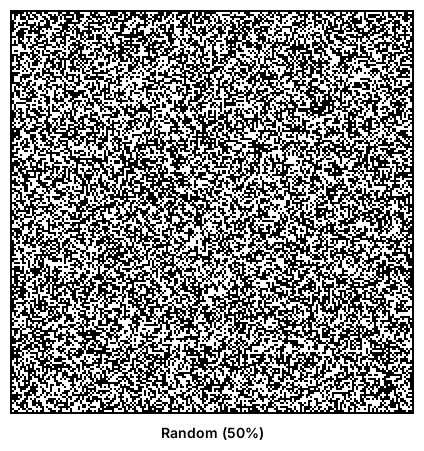

In [ ]:
def generate_random(ratio: float = 0.5, brush: Brush = Brush()) -> Generator:

    def generator(context: Context) -> None:
        for x, y in context.points():
            if context.rng.random() <= ratio:
                context.draw(x, y, brush)

        global _data
        _data = context.data

    return generator


render(generate_random(ratio=0.5), title="Random (50%)")


### Random Placement

This examples places random tiles on the map, it is effectively the same as the random
choice generator, but will be faster for smaller fill ratios, and potentially much
slower on higher fill ratios.

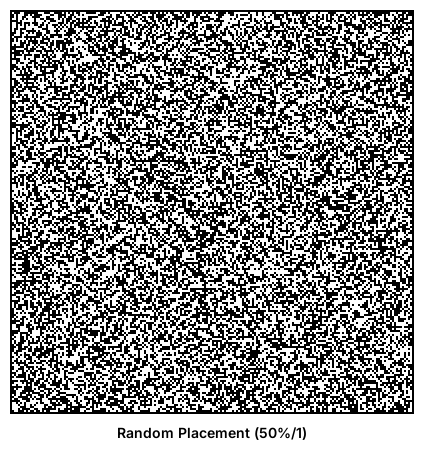

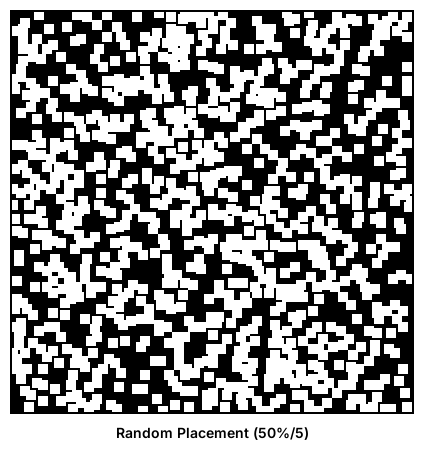

In [ ]:

def generate_random_placement(ratio: float = 0.5, brush: Brush = Brush()) -> Generator:

    def generator(context: Context) -> None:
        total = context.size()
        count = context.count_of(brush.value)

        while count / total < ratio:
            x, y = context.random_point()

            if context.data[y][x] == WALL:
                count += context.draw(x, y, brush)

    return generator


render(generate_random_placement(ratio=0.5), title="Random Placement (50%/1)")

render(generate_random_placement(ratio=0.5, brush=Brush(size=5)),
       title="Random Placement (50%/5)")


### Simplex Noise

[Simplex Noise](https://en.wikipedia.org/wiki/Simplex_noise) is a type of 
[gradient noise](https://en.wikipedia.org/wiki/Gradient_noise). It generates random
values that tend to be more similar to their neighbours than value noise, which makes
things look smoother and more natural.

By rounding the values generated by a gradient noise function we get a map that is more
interesting with smooth natural looking edges.

The downside is that the carved out areas are not contiguous, which makes the strategy
unviable on its own, but could potentially be combined with some form of tunnel carving
to provide a viable map.

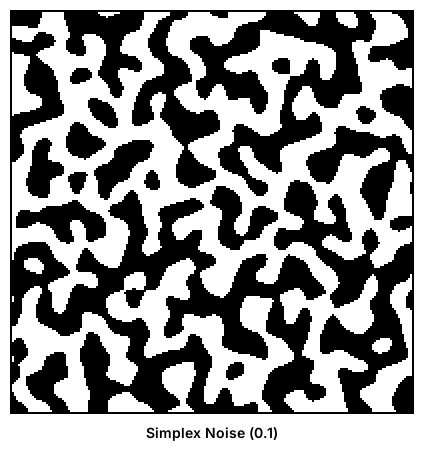

In [ ]:
def generate_simplex(scale: float = 0.1, brush: Brush = Brush()) -> Generator:
    def generator(context: Context) -> None:
        generator = opensimplex.OpenSimplex(context.seed)

        for x, y in context.points():
            if generator.noise2(x * scale, y * scale) > 0:
                context.draw(x, y, brush)

    return generator


render(generate_simplex(scale=0.1), title="Simplex Noise (0.1)")


### Drunkards Walk

The drunkards walk algorithm is a type of random walk, where an miner moves in a random
direction each step, carving out the map as it goes, until it ultimately passes out and
a new miner is spawned at the start point.

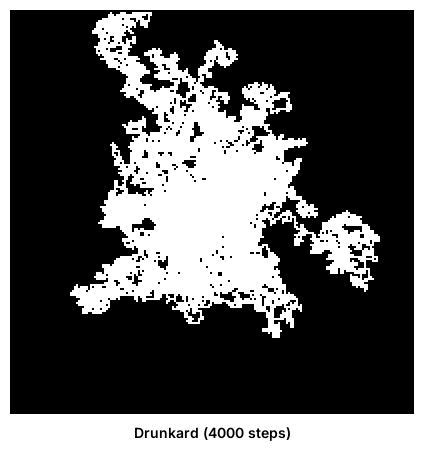

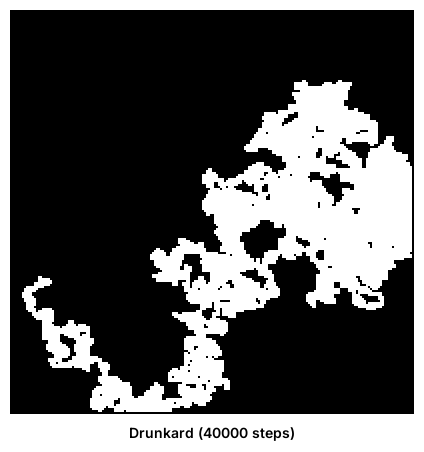

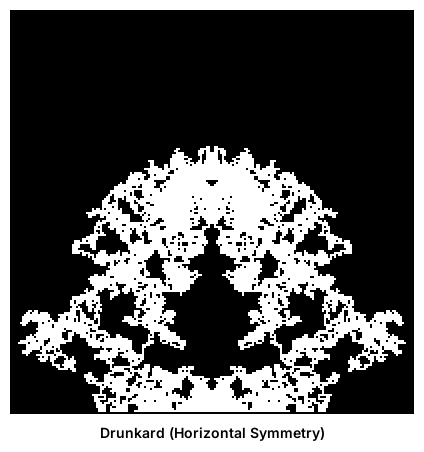

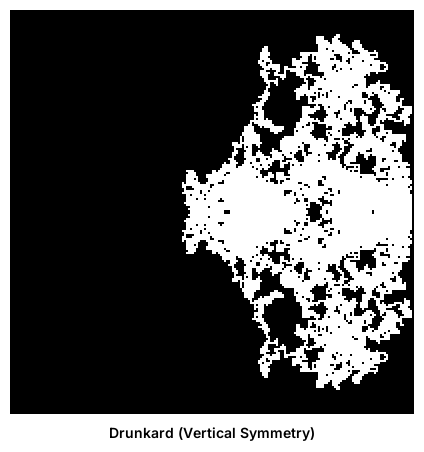

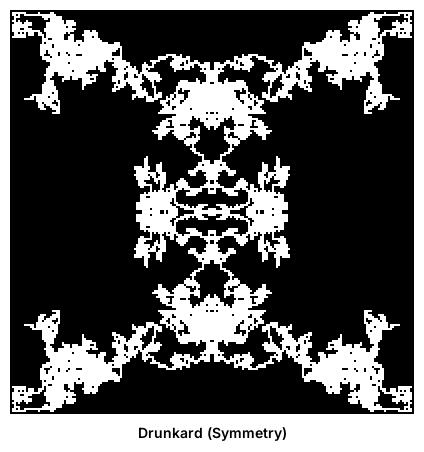

In [ ]:
def generate_drunkard(ratio: float = 0.25, max_steps: int = 50000, max_walkers: int = 100, brush: Brush = Brush()) -> Generator:

    def generator(context: Context) -> None:
        total = context.size()
        count = context.count_of(brush.value)

        defaults = (context.width // 2, context.height // 2, max_steps)

        x, y, steps = defaults

        walkers = 0

        while count / total < ratio:
            count += context.draw(x, y, brush)

            x, y = context.random_neighbour_for(x, y)
            x, y = context.constrain(x, y)

            steps -= 1

            if steps == 0:
                x, y, steps = defaults
                walkers += 1

            if walkers >= max_walkers:
                break

    return generator


render(
    generate_drunkard(ratio=0.25, max_steps=4000),
    title="Drunkard (4000 steps)",
)

render(
    generate_drunkard(ratio=0.25, max_steps=40000, brush=Brush(size=2)),
    title="Drunkard (40000 steps)",
)

render(
    generate_drunkard(ratio=0.25, max_steps=40000,
                      brush=Brush(symmetry="horizontal")),
    title="Drunkard (Horizontal Symmetry)",
)

render(
    generate_drunkard(ratio=0.25, max_steps=40000,
                      brush=Brush(symmetry="vertical")),
    title="Drunkard (Vertical Symmetry)",
)

render(
    generate_drunkard(ratio=0.25, max_steps=40000,
                      brush=Brush(symmetry="both")),
    title="Drunkard (Symmetry)",
)


### Rectangle

A simple generator that generates a rectangle at the given position.

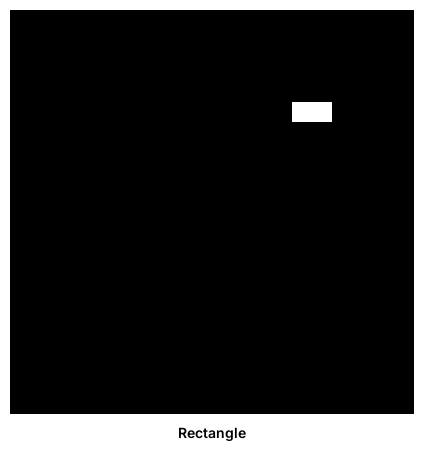

In [ ]:
def generate_rectangle(width: int, height: int | None = None, x: int | None = None, y: int | None = None, value: int = AIR) -> Generator:
    height = height if height is not None else width

    brush = Brush(size=1, value=value)

    def generator(context: Context) -> None:
        nx = x if x is not None else context.width // 2
        ny = y if y is not None else context.height // 2

        nx -= width // 2
        ny -= height // 2

        for ix, iy in context.points_for(nx, ny, width, height):
            if not context.contains(ix, iy):
                continue

            context.draw(ix, iy, brush)

    return generator


render(
    generate_rectangle(width=20, height=10, x=150, y=50),
    title="Rectangle",
)


### Diffusion Limited Aggregation

Diffusion limited aggregation uses random walkers to choose cells adjacent to a set of
"seed" cells. The walkers move around similar to a drunkards walk, and then when they
step into the carved area, the cell they stepped from is added.

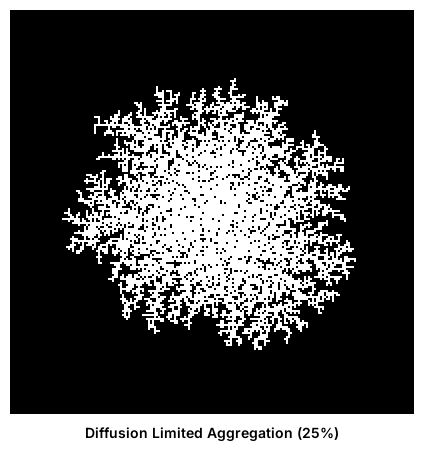

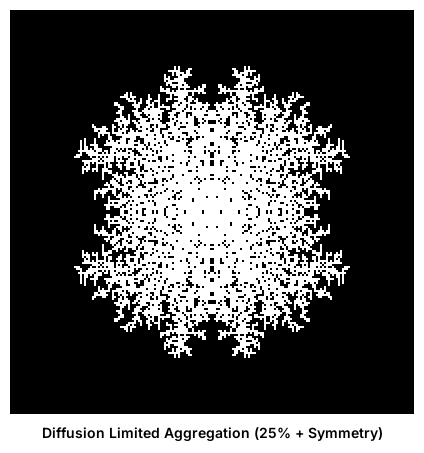

In [ ]:
def generate_dla(ratio: float = 0.25, max_steps: int = 100, max_walkers: int = 100000, brush: Brush = Brush(size=1)) -> Generator:

    def generator(context: Context) -> None:
        total = context.size()
        count = context.count_of(brush.value)

        walkers = 0

        x, y = context.random_point()
        steps = max_steps

        while count / total < ratio:
            if steps <= 0:
                x, y = context.random_point()
                steps = max_steps
                walkers += 1

            if walkers >= max_walkers:
                break

            if any(
                context.value_for(x + dx, y + dy) == brush.value
                for dx, dy in ((-1, 0), (1, 0), (0, -1), (0, 1))
            ):
                count += context.draw(x, y, brush)
                steps = 0

            x, y = context.random_neighbour_for(x, y)

            steps -= 1

            if not context.contains(x, y):
                steps = 0

    return generator


render(
    chain(
        generate_rectangle(width=5),
        generate_dla(ratio=0.25, brush=Brush(size=1)),
    ),
    title="Diffusion Limited Aggregation (25%)",
)

render(
    chain(
        generate_rectangle(width=5),
        generate_dla(ratio=0.25, brush=Brush(size=1, symmetry="both")),
    ),
    title="Diffusion Limited Aggregation (25% + Symmetry)",
)


### Framed

A simple generator that adds a frame to the output of an existing generator.

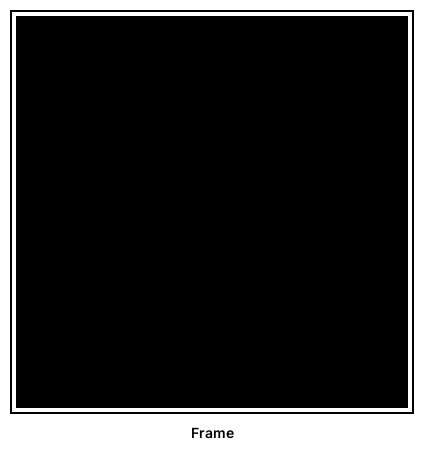

In [ ]:
def generate_frame(brush: Brush = Brush(size=1, value=WALL)) -> Generator:

    def generator(context: Context) -> None:
        o1 = brush.size // 2
        o2 = brush.size - o1

        for x in range(0, context.width):
            context.draw(x, o1, brush)
            context.draw(x, context.height - o2, brush)

        for y in range(0, context.height):
            context.draw(o1, y, brush)
            context.draw(context.width - o2, y, brush)

    return generator


render(
    chain(
        generate_frame(brush=Brush(size=2, value=AIR)),
    ),
    title="Frame"
)


### Filled

A simple generator that fills the map with a single tile value. In isolation this is
possibly the least interesting of all generators.

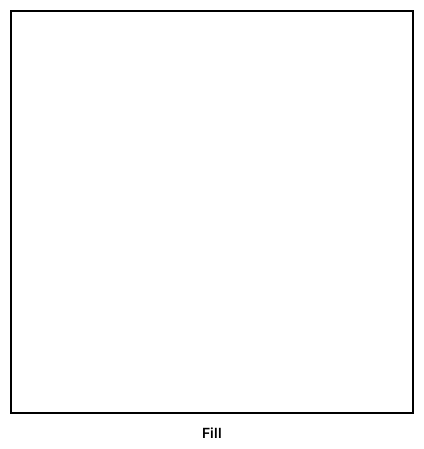

In [ ]:
def generate_fill(value: int = AIR) -> Generator:
    brush = Brush(value=value)

    def generator(context: Context) -> None:
        for x, y in context.points():
            context.draw(x, y, brush)

    return generator


render(chain(generate_fill()), title="Fill")


### Cellular Automata

Cellular automata are most famously used in conway's game of life, the map is iteratively
transformed based on some simple rules about the neighbourhood of 9 tiles it belongs to.

When fed a random map, the automata will carve out interesting patterns, but the results 
are not always contiguous spaces.

The automata also tend to have a smoothing on the output of other generators.

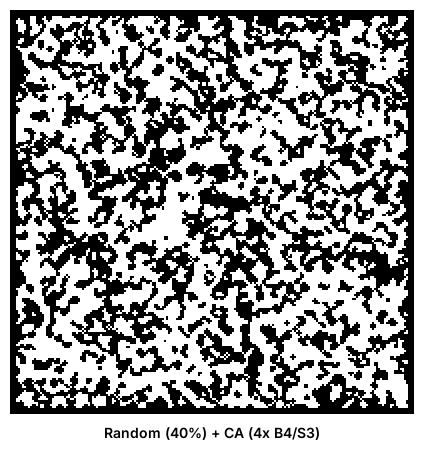

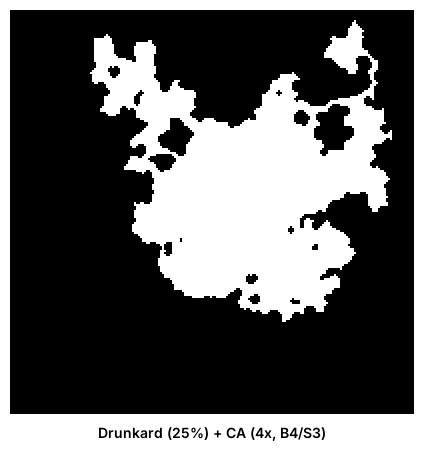

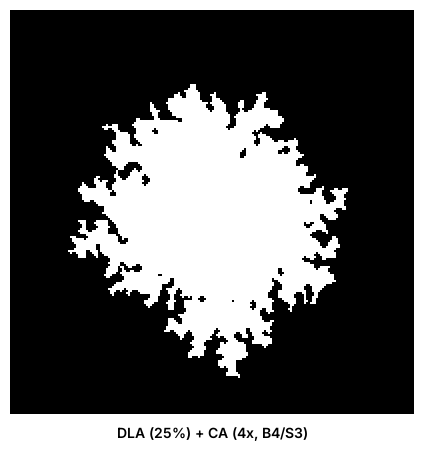

In [ ]:

def generate_cellular_automata(
    rounds: int = 5,
    birth: int = 4,
    death: int = 3,
    live: int = AIR,
    dead: int = WALL,
) -> Generator:
    live_brush = Brush(size=1, value=live)
    dead_brush = Brush(size=1, value=dead)

    def generator(context: Context) -> None:
        for _ in range(rounds):
            current = context.copy()

            for x, y in context.points():
                neighbours = current.neighbours_for(x, y, live, dead)

                if neighbours < death:
                    context.draw(x, y, dead_brush)

                if neighbours > birth:
                    context.draw(x, y, live_brush)

    return generator


render(
    chain(
        generate_random(ratio=0.4),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=4, birth=4, death=3),
    ),
    title="Random (40%) + CA (4x B4/S3)",
)

render(
    chain(
        generate_drunkard(ratio=0.25, max_steps=4000),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=4, birth=4, death=3),
    ),
    title="Drunkard (25%) + CA (4x, B4/S3)",
)

render(
    chain(
        generate_rectangle(width=5),
        generate_dla(ratio=0.25, brush=Brush(size=1)),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=4, birth=4, death=3),
    ),
    title="DLA (25%) + CA (4x, B4/S3)",
)


### Flood Fill

Flood fill expands from a point outwards, collecting all tiles that are in a contiguous
region.

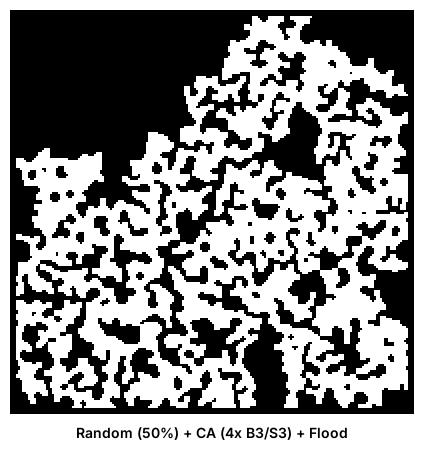

In [ ]:
def flood(context: Context, table: list[list[int]], x: int, y: int, region_id: int, value: int) -> set[tuple[int, int]]:
    stack = [(x, y)]
    result = set()

    while stack:
        ix, iy = stack.pop()

        if table[iy][ix] != 0 or context.value_for(ix, iy) == value:
            continue

        table[iy][ix] = region_id

        result.add((ix, iy))

        if ix > 0 and table[iy][ix - 1] == 0:
            stack.append((ix - 1, iy))

        if ix < context.width - 1 and table[iy][ix + 1] == 0:
            stack.append((ix + 1, iy))

        if iy > 0 and table[iy - 1][ix] == 0:
            stack.append((ix, iy - 1))

        if iy < context.height - 1 and table[iy + 1][ix] == 0:
            stack.append((ix, iy + 1))

    return result


def generate_flood(value: int = WALL) -> Generator:
    brush = Brush(size=1, value=value)

    def generator(context: Context) -> None:
        table = [[0] * context.width for _ in range(context.height)]
        regions: list[set[tuple[int, int]]] = []
        identifier = 1

        for x, y in context.points():
            if table[y][x] != 0 or context.value_for(x, y) == value:
                continue

            regions.append(flood(context, table, x, y, identifier, value))

            identifier += 1

        regions.sort(key=len, reverse=True)

        for region in regions[1:]:
            for x, y in region:
                context.draw(x, y, brush)

    return generator


render(
    chain(
        generate_random_placement(ratio=0.5, brush=Brush(size=3)),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=4),
        generate_flood(),
    ),
    title="Random (50%) + CA (4x B3/S3) + Flood",
)


## Room Based Generators

Room based generators are a subset of procedural generation that generate maps by
placing rooms, and then connecting them via corridors.

They have an advantage over the basic generators in that the rooms can be used to
more easily place place points of interest, but often have less variety in the shape.

To generate a room based dungeon we first generate a set of non overlapping rectangles,
and calculate the edges that connect them to other rooms, then we carve out the rooms
and connect them with tunnels.

### Generator

A generator that generates a set of rooms and the edges that connects them, then employs
other generators to carve out the rooms and tunnels.

In [ ]:
def generate_rooms(
    rooms: RoomGenerator,
    edges: EdgeGenerator,
    tunnels: TunnelGenerator,
    inner: Generator = generate_fill()
) -> Generator:

    def generator(context: Context) -> None:
        room_list = rooms(context)
        edge_list = edges(room_list, context.rng)

        for x, y, w, h in room_list:
            inner(context.subcontext(x, y, w, h))

        for i, j in edge_list:
            x1, y1 = center_for_rect(*room_list[i])
            x2, y2 = center_for_rect(*room_list[j])

            tunnels(context, x1, y1, x2, y2)

    return generator


### Edge Generators

#### Naive edge generator

An edge generator that connects rooms in the order they were generated.

In [ ]:
def edge_naive(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
    return [(i, i + 1) for i in range(len(rooms) - 1)]


#### Sorted edge generator

An edge generator that sorts a set of rooms by their x coordinate, and then connects 
them in order.

In [ ]:
def edge_sorted(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
    indexed = list(enumerate(rooms))

    indexed.sort(key=lambda r: r[1][0])

    return [(indexed[i][0], indexed[i + 1][0]) for i in range(len(rooms) - 1)]


#### Boyer-Watson edge generator

An edge generator using the Boyer-Watson algorithm to generate non-overlapping edges
between the rooms.

In [ ]:
type Triangle = tuple[Point, Point, Point]


def distance(a: Point, b: Point) -> float:
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def circumcircle(triangle: Triangle) -> tuple[Point, int]:
    ax, ay = triangle[0]
    bx, by = triangle[1]
    cx, cy = triangle[2]

    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))

    x = int(round((
        (ax ** 2 + ay ** 2) * (by - cy) +
        (bx ** 2 + by ** 2) * (cy - ay) +
        (cx ** 2 + cy ** 2) * (ay - by)
    ) / d))

    y = int(round((
        (ax ** 2 + ay ** 2) * (cx - bx) +
        (bx ** 2 + by ** 2) * (ax - cx) +
        (cx ** 2 + cy ** 2) * (bx - ax)
    ) / d))

    return (x, y), int(round(distance((x, y), triangle[0])))


def edges_for_triangle(triangle: Triangle) -> set[tuple[Point, Point]]:
    return {
        (triangle[0], triangle[1]),
        (triangle[1], triangle[2]),
        (triangle[2], triangle[0]),
    }


def edge_boyer_watson(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
    points = [center_for_rect(*room) for room in rooms]

    lookup = {point: i for i, point in enumerate(points)}

    triangulation: list[Triangle] = []

    bounds = [
        min(x for x, _ in points) - 10,
        min(y for _, y in points) - 10,
        max(x for x, _ in points) + 10,
        max(y for _, y in points) + 10,
    ]

    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]

    triangle = [
        (bounds[0] - width / 2, bounds[1]),
        (bounds[2] + width / 2, bounds[1]),
        (bounds[0] + width / 2, bounds[3] + height),
    ]

    triangulation.append((triangle, circumcircle(triangle)))

    for point in points:
        bad_triangles = []

        for i, (triangle, circle) in enumerate(triangulation):
            if distance(point, circle[0]) < circle[1]:
                bad_triangles.append(i)

        polygon: set[tuple[Point, Point]] = set()

        for i in bad_triangles:
            triangle = triangulation[i][0]

            edges = edges_for_triangle(triangle)

            for j in bad_triangles:
                other = triangulation[j][0]

                if i == j:
                    continue

                other_edges = edges_for_triangle(other)

                for edge in copy.copy(edges):
                    if edge not in other_edges and edge[::-1] not in other_edges:
                        continue

                    edges.remove(edge)

            polygon.update(edges)

        for i in sorted(bad_triangles, reverse=True):
            triangulation.pop(i)

        for edge in polygon:
            triangle = [
                point,
                edge[0],
                edge[1],
            ]

            triangulation.append((triangle, circumcircle(triangle)))

    result = []

    for i in range(len(triangulation) - 1, -1, -1):
        triangle = triangulation[i][0]

        if triangle[0] not in points or triangle[1] not in points or triangle[2] not in points:
            triangulation.pop(i)
            continue

        result.append((lookup[triangle[0]], lookup[triangle[1]]))
        result.append((lookup[triangle[1]], lookup[triangle[2]]))
        result.append((lookup[triangle[2]], lookup[triangle[0]]))

    image = PIL.Image.new("RGB", (WIDTH, HEIGHT), (255, 255, 255))

    draw = PIL.ImageDraw.Draw(image)

    for x, y in points:
        draw.circle(xy=(x, y), radius=2, fill=(0, 0, 0))

    for triangle, _ in triangulation:
        draw.polygon(xy=triangle, outline=(255, 0, 0))

    return result


#### Grid edge generator

An edge generator that generates connections between rooms arranged as a grid.

In [ ]:
def edge_grid(x, y) -> EdgeGenerator:

    def generator(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
        result = list()

        for iy in range(y):
            for ix in range(x):
                index = iy * x + ix

                if ix > 0:
                    result.append((index, index - 1))

                if iy > 0:
                    result.append((index, index - x))

                if ix < x - 1:
                    result.append((index, index + 1))

                if iy < y - 1:
                    result.append((index, index + x))

        return result

    return generator


### Maze generators


#### Prim's algorithm

In [ ]:
def maze_prims(inner: EdgeGenerator = edge_boyer_watson) -> EdgeGenerator:

    def generator(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
        points = [center_for_rect(*room) for room in rooms]
        length = len(points)

        edges = inner(rooms, rng)

        weights = [[0] * length for _ in range(length)]

        for a, b in edges:
            weights[a][b] = distance(points[a], points[b])
            weights[b][a] = weights[a][b]

        cost = [math.inf] * length

        edge: list[int | None] = [None] * length

        forest = set()

        start = rng.randint(0, length - 1)

        cost[start] = 0

        for _ in range(length):
            min_cost = math.inf

            for i in range(length):
                if cost[i] <= min_cost and i not in forest:
                    min_cost = cost[i]

                    v = i

            if min_cost != math.inf:
                options: list[int] = []

                for i in range(length):
                    if cost[i] == min_cost and i not in forest:
                        options.append(i)

                v = rng.choice(options)

            forest.add(v)

            for w in range(length):
                if weights[v][w] != 0 and w not in forest and cost[w] > weights[v][w]:
                    cost[w] = weights[v][w]
                    edge[w] = v

        image = PIL.Image.new("L", (WIDTH, HEIGHT), 0)

        draw = PIL.ImageDraw.Draw(image)

        for a, b in edges:
            draw.line(xy=(points[a], points[b]), fill=64)

        for v in forest:
            if edge[v] is None:
                continue

            draw.line(xy=(points[v], points[edge[v]]), fill=255)

        display(image)

        return [(v, edge[v]) for v in forest if edge[v] is not None]

    return generator


### Tunnel Generators

#### Simple tunnel generator

A tunnel generator that connects the centres of two rooms by moving once in a straight
line along each of the cardinal axis.

In [ ]:
def tunnel_simple(brush: Brush = Brush(size=3)) -> TunnelGenerator:

    def generator(context: Context, x1: int, y1: int, x2: int, y2: int) -> None:
        if context.rng.randint(0, 1):
            for x in range(min(x1, x2), max(x1, x2) + 1):
                context.draw(x, y1, brush)

            for y in range(min(y1, y2), max(y1, y2) + 1):
                context.draw(x2, y, brush)
        else:
            for y in range(min(y1, y2), max(y1, y2) + 1):
                context.draw(x1, y, brush)

            for x in range(min(x1, x2), max(x1, x2) + 1):
                context.draw(x, y2, brush)

    return generator


### Room Generators

#### Simple room generator

A room generator that places rooms at random, discarding any that overlap.

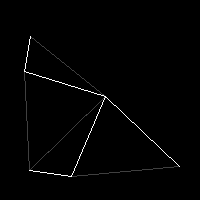

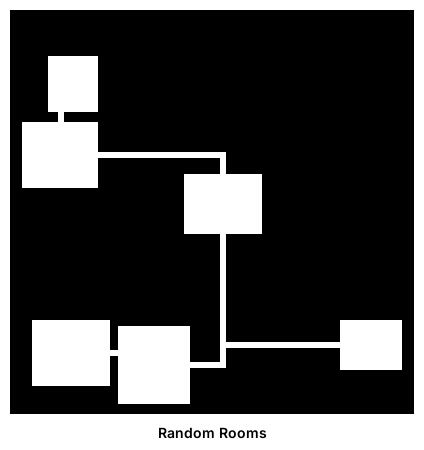

In [ ]:
def room_random(
    count: int,
    min_width: int,
    min_height: int,
    max_width: int,
    max_height: int,
    spacing: int = 1
) -> RoomGenerator:

    def generator(context: Context) -> list[Rect]:
        result = []

        for _ in range(count):
            w = context.rng.randint(min_width, max_width)
            h = context.rng.randint(min_height, max_height)

            if w > context.width - spacing * 2 or h > context.height - spacing * 2:
                continue

            x = context.rng.randint(spacing, context.width - spacing - w)
            y = context.rng.randint(spacing, context.height - spacing - h)

            if any(
                x <= ox + ow and x + w >= ox and y <= oy + oh and y + h >= oy
                for ox, oy, ow, oh in result
            ):
                continue

            result.append((x, y, w, h))

        return result

    return generator


render(
    generate_rooms(
        room_random(count=10, min_width=25, min_height=25,
                    max_width=40, max_height=40),
        maze_prims(),
        tunnel_simple(),
    ),
    title="Random Rooms",
)


#### Binary Space Partitioning room generator

This room generator uses binary space partitioning to generate a set of rectangles then
randomly selects some of those rectangles to be rooms.

The rectangles are produced by recursively splitting regions of the map in half along
one of the cardinal axis until the regions are too small to be divided further.

This makes it easier to the desired number of rooms, as assuming a sensible minimum size
is specified to generate enough rectangles, the algorithm should be able place the 
desired number of rooms.

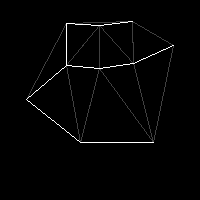

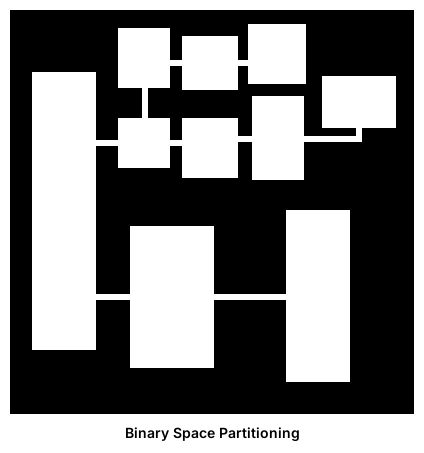

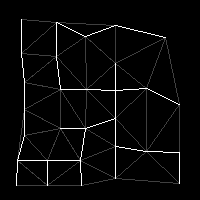

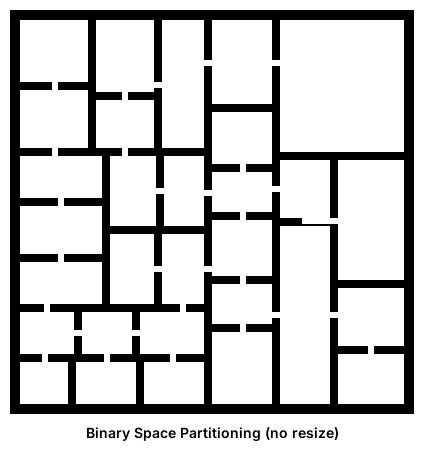

In [ ]:
class BinaryNode[T]:
    value: T
    left: typing.Self | None
    right: typing.Self | None

    def __init__(self, value: T) -> None:
        self.value = value
        self.left = None
        self.right = None

    def to_list(self) -> list[T]:
        if self.left and self.right:
            return [*self.left.to_list(), *self.right.to_list()]

        return [self.value]


def room_bsp(count: int, spacing: int = 1, min_width: int = 30, min_height: int = 30, resize: bool = True) -> RoomGenerator:

    def generator(context: Context) -> list[Rect]:
        root = BinaryNode((spacing, spacing, context.width -
                          spacing * 2, context.height - spacing * 2))

        nodes = [root]

        size = 1

        while nodes and size < count:
            index = context.rng.randint(0, len(nodes) - 1)

            node = nodes.pop(index)

            x, y, w, h = node.value

            if (context.rng.randint(0, 1) == 1 or h < min_height * 2 + spacing) and w >= min_width * 2 + spacing:
                split = context.rng.randint(min_width, w - min_width - spacing)

                node.left = BinaryNode((x, y, split, h))
                node.right = BinaryNode(
                    (x + split + spacing, y, w - split - spacing, h))

                if split > min_width:
                    nodes.append(node.left)

                if w - split - spacing > min_width:
                    nodes.append(node.right)

                size += 1

            elif h >= min_height * 2 + spacing:
                split = context.rng.randint(
                    min_height, h - min_height - spacing)

                node.left = BinaryNode((x, y, w, split))
                node.right = BinaryNode(
                    (x, y + split + spacing, w, h - split - spacing))

                if split > min_height:
                    nodes.append(node.left)

                if h - split - spacing > min_height:
                    nodes.append(node.right)

                size += 1

        spaces = root.to_list()

        result = []

        for x, y, w, h in spaces:
            if resize:
                iw = context.rng.randint(min_width, w)
                ih = context.rng.randint(min_height, h)
                ix = x + (w - iw) // 2
                iy = y + (h - ih) // 2
            else:
                ix, iy, iw, ih = x, y, w, h

            result.append((ix, iy, iw, ih))

        return result

    return generator


render(
    generate_rooms(
        room_bsp(count=10, spacing=5, min_width=25, min_height=25),
        maze_prims(),
        tunnel_simple(),
    ),
    title="Binary Space Partitioning",
)

render(
    generate_rooms(
        room_bsp(count=30, spacing=4, min_width=20,
                 min_height=20, resize=False),
        maze_prims(),
        tunnel_simple(),
    ),
    title="Binary Space Partitioning (no resize)",
    width=200,
    height=200
)


#### Grid room generator

Places rooms in a grid pattern, with each room being a uniform shape and size.

##### Generator

In [ ]:
def room_grid(
    x: int,
    y: int,
    spacing: int = 1
) -> RoomGenerator:

    def generator(context: Context) -> list[Rect]:
        width = (context.width + spacing) // x - spacing
        height = (context.height + spacing) // y - spacing

        if width < 1 or height < 1:
            raise ValueError("Grid does not fit in context")

        ox = (context.width - (width + spacing) * x + spacing) // 2
        oy = (context.height - (height + spacing) * y + spacing) // 2

        result = []

        for iy in range(y):
            for ix in range(x):
                result.append(
                    (
                        ox + ix * (width + spacing),
                        oy + iy * (height + spacing),
                        width,
                        height
                    )
                )

        return result

    return generator


##### Prim's algorithm

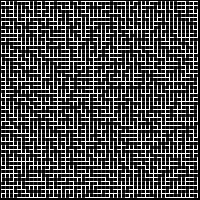

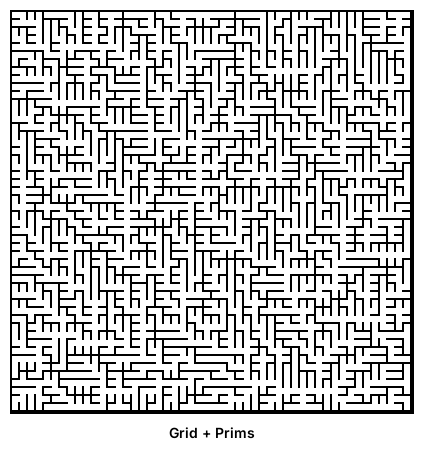

In [ ]:
render(
    generate_rooms(
        room_grid(x=50, y=50),
        maze_prims(edge_grid(x=50, y=50)),
        tunnel_simple(brush=Brush(size=3)),
    ),
    title="Grid + Prims",
)


##### Aldous-Broder algorithm

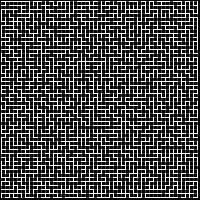

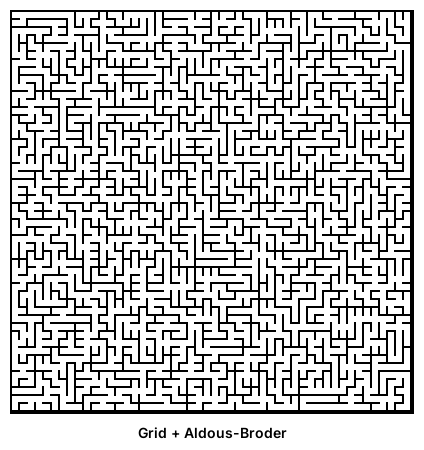

In [ ]:
def maze_aldous_broder(inner: EdgeGenerator = edge_boyer_watson) -> EdgeGenerator:

    def generator(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
        points = [center_for_rect(*room) for room in rooms]
        length = len(points)

        edges = inner(rooms, rng)

        neighbours = [[] for _ in range(length)]

        for a, b in edges:
            if b not in neighbours[a]:
                neighbours[a].append(b)

            if a not in neighbours[b]:
                neighbours[b].append(a)

        visited = [False] * length

        current = rng.randint(0, length - 1)
        visited[current] = True

        results = []

        while not all(visited):

            neighbour = rng.choice(neighbours[current])

            if not visited[neighbour]:
                results.append((current, neighbour))

                visited[neighbour] = True

            current = neighbour

        image = PIL.Image.new("L", (WIDTH, HEIGHT), 0)

        draw = PIL.ImageDraw.Draw(image)

        for a, b in edges:
            draw.line(xy=(points[a], points[b]), fill=64)

        for a, b in results:

            draw.line(xy=(points[a], points[b]), fill=255)

        display(image)

        return results

    return generator


render(
    generate_rooms(
        room_grid(x=50, y=50),
        maze_aldous_broder(edge_grid(x=50, y=50)),
        tunnel_simple(brush=Brush(size=3)),
    ),
    title="Grid + Aldous-Broder",
)


##### Randomized Depth-First Search algorithm

Also known as Recursive Backtracking algorithm.

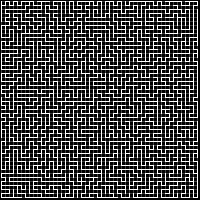

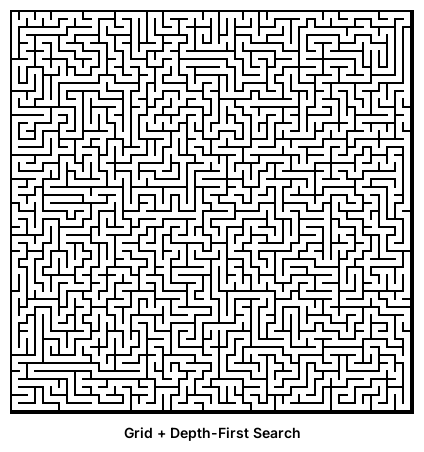

In [ ]:
def maze_dfs(inner: EdgeGenerator = edge_boyer_watson) -> EdgeGenerator:
    def generator(rooms: list[Rect], rng: random.Random) -> list[tuple[int, int]]:
        points = [center_for_rect(*room) for room in rooms]
        length = len(points)

        edges = inner(rooms, rng)

        start = rng.randint(0, length - 1)

        visited = [False] * length

        neighbours = [[] for _ in range(length)]

        for a, b in edges:
            if b not in neighbours[a]:
                neighbours[a].append(b)

            if a not in neighbours[b]:
                neighbours[b].append(a)

        results = []

        stack = [start]

        visited[start] = True

        while stack:
            current = stack.pop()

            if all(visited[i] for i in neighbours[current]):
                continue

            stack.append(current)

            neighbour = rng.choice(
                [i for i in neighbours[current] if not visited[i]])

            results.append((current, neighbour))

            visited[neighbour] = True

            stack.append(neighbour)

        image = PIL.Image.new("L", (WIDTH, HEIGHT), 0)

        draw = PIL.ImageDraw.Draw(image)

        for a, b in edges:
            draw.line(xy=(points[a], points[b]), fill=64)

        for a, b in results:
            draw.line(xy=(points[a], points[b]), fill=255)

        display(image)

        return results

    return generator


render(
    generate_rooms(
        room_grid(x=50, y=50),
        maze_dfs(edge_grid(x=50, y=50)),
        tunnel_simple(brush=Brush(size=3)),
    ),
    title="Grid + Depth-First Search",
)


## Biome Generators

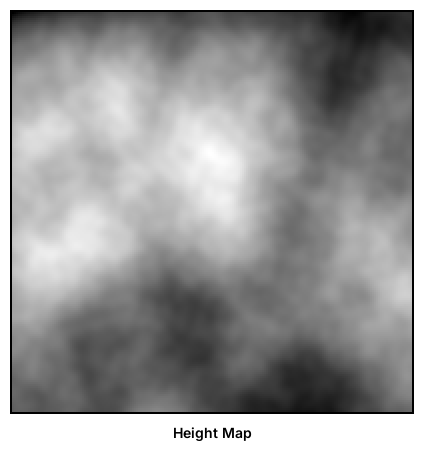

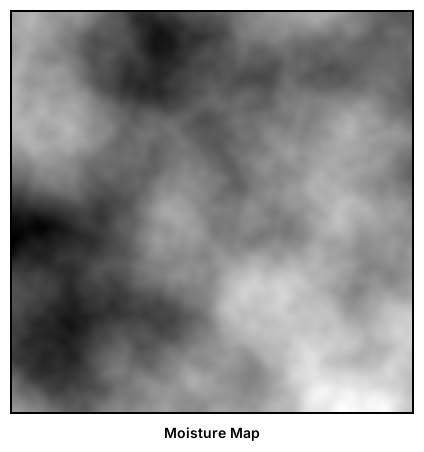

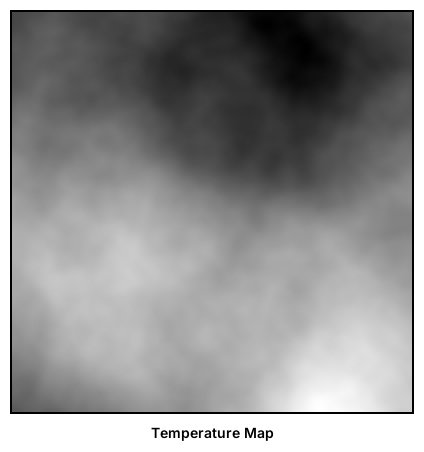

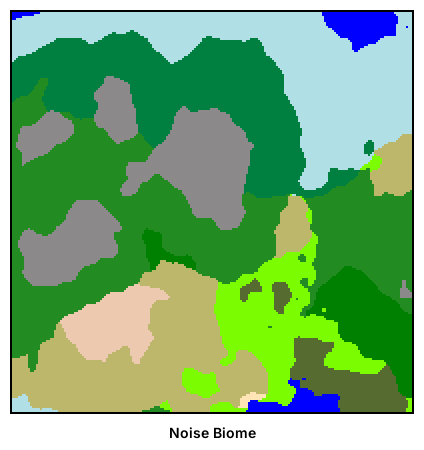

In [ ]:
def fbm(
    noise: opensimplex.OpenSimplex,
    x: float,
    y: float,
    octaves: int,
    frequency: float = 0.1,
    persistence: float = 0.5,
    lacunarity: float = 2.0,
) -> float:
    value = 0.0
    amplitude = 0.5
    max_amplitude = 0.0

    for _ in range(octaves):
        value += float(noise.noise2(x * frequency, y * frequency)) * amplitude
        max_amplitude += amplitude
        amplitude *= persistence
        frequency *= lacunarity

    return value / max_amplitude


def generate_noise_biome(to_biome: typing.Callable[[float, float, float], int]) -> Generator:
    def generator(context: Context) -> None:
        generator = opensimplex.OpenSimplex(context.seed)

        height_map: FloatMap = [[0.0 for _ in range(context.width)]
                                for _ in range(context.height)]

        moisture_map: FloatMap = [[0.0 for _ in range(context.width)]
                                  for _ in range(context.height)]

        temperature_map: FloatMap = [[0.0 for _ in range(context.width)]
                                     for _ in range(context.height)]

        for x, y in context.points():
            height_map[y][x] = fbm(
                generator,
                x,
                y,
                octaves=6,
                frequency=0.005
            )
            moisture_map[y][x] = fbm(
                generator,
                x + 1000,
                y + 1000,
                octaves=6,
                frequency=0.005
            )

            temperature_map[y][x] = fbm(
                generator,
                x + 2000,
                y + 2000,
                octaves=6,
                frequency=0.005
            )

        height_map = normalize_floats(height_map)
        moisture_map = normalize_floats(moisture_map)
        temperature_map = normalize_floats(temperature_map)

        render_data(
            to_map(height_map),
            context.width,
            context.height,
            title="Height Map",
            palette=GRAYSCALE_PALETTE,
        )

        render_data(
            to_map(moisture_map),
            context.width,
            context.height,
            title="Moisture Map",
            palette=GRAYSCALE_PALETTE,
        )

        render_data(
            to_map(temperature_map),
            context.width,
            context.height,
            title="Temperature Map",
            palette=GRAYSCALE_PALETTE,
        )

        context.data = [
            [
                to_biome(height_map[y][x], moisture_map[y]
                         [x], temperature_map[y][x])
                for x in range(context.width)
            ]
            for y in range(context.height)
        ]

    return generator


def to_biome(height: float, moisture: float, temperature: float) -> int:
    # below sea level

    if height < 0.15:
        return BIOME_OCEAN

    if height < 0.2 and moisture < 0.6 and temperature > 0.4:
        return BIOME_BEACH

    # lowland level

    if height < 0.5:
        if temperature < 0.4:
            return BIOME_TUNDRA

        if moisture < 0.4 and temperature > 0.7:
            return BIOME_DESERT

        if moisture < 0.6:
            return BIOME_SAVANNA

        if moisture < 0.8:
            return BIOME_PLAINS

        return BIOME_SWAMP

    # highland level

    if height < 0.8:
        if temperature < 0.4:
            return BIOME_TAIGA

        if moisture < 0.5 or temperature < 0.7:
            return BIOME_FOREST

        return BIOME_JUNGLE

    # mountain level

    return BIOME_MOUNTAIN


render(generate_noise_biome(to_biome), title="Noise Biome",
       palette=BIOME_PALETTE)


## Combined Generators

### Random Placement + Cellular Automata + Flood Fill

Combining large random placement with cellular automata can produce interesting cavern
like maps.

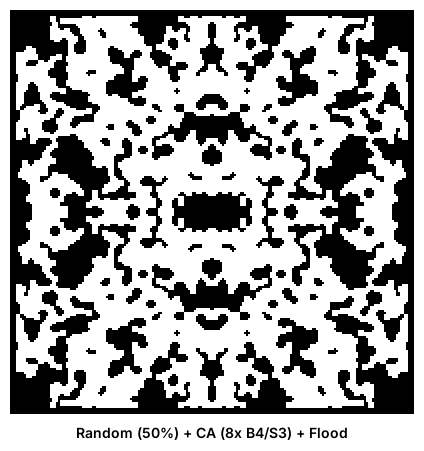

In [ ]:
render(
    chain(
        generate_random_placement(
            ratio=0.5, brush=Brush(size=3, symmetry="both")),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=8),
        generate_flood(),
        generate_frame(),
    ),
    title="Random (50%) + CA (8x B4/S3) + Flood",
)


### Drunkards Walk + Cellular Automata

Symetrical Drunkards Walk combined with cellular automata gives a nice central cavern
with cave like edges.

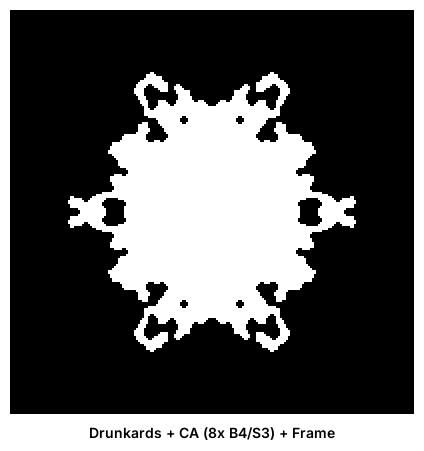

In [ ]:
render(
    chain(
        generate_drunkard(ratio=0.25, max_steps=1000,
                          brush=Brush(size=2, symmetry="both")),
        generate_frame(brush=Brush(size=2, value=WALL)),
        generate_cellular_automata(rounds=8),
    ),
    title="Drunkards + CA (8x B4/S3) + Frame",
)


Diffusion Limited Aggregation + Cellular Automata

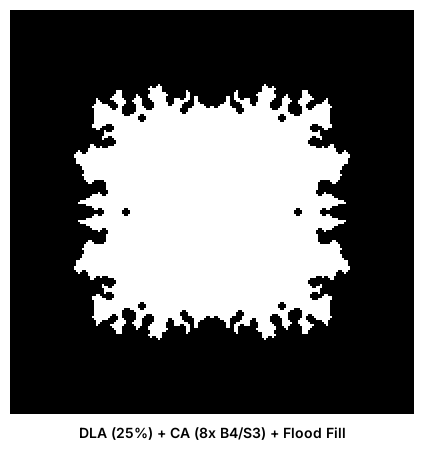

In [ ]:
render(
    chain(
        generate_rectangle(width=5),
        generate_dla(ratio=0.25, brush=Brush(size=1, symmetry="both")),
        generate_cellular_automata(rounds=8),
    ),
    title="DLA (25%) + CA (8x B4/S3) + Flood Fill",
)


### Binary Space Partitioning + Drunkards Walk

By combining Binary Space Partitioning with Drunkards Walk for room generation we get a
map that looks like a series of caves, then using Diffusion Limited Aggregation further
distorts the edges of the map, before Cellular Automata smooths the edges, and Flood 
Fill removes any small regions that were created in the process.

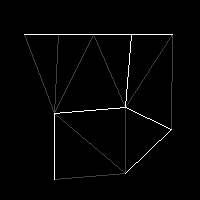

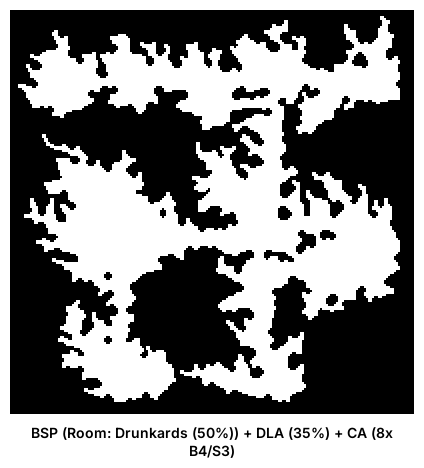

In [ ]:
render(
    chain(
        generate_rooms(
            room_bsp(count=10, spacing=10, min_width=20,
                     min_height=20, resize=False),
            maze_prims(),
            tunnel_simple(),
            generate_drunkard(ratio=0.2, max_steps=400, brush=Brush(size=2)),
        ),
        generate_dla(ratio=0.35, brush=Brush(size=2)),
        generate_cellular_automata(rounds=8),
        generate_flood(),
    ),
    title="BSP (Room: Drunkards (50%)) + DLA (35%) + CA (8x B4/S3)",
)


#### With No Resize

More rooms and disabling the resizing gives a more room-like cave map.

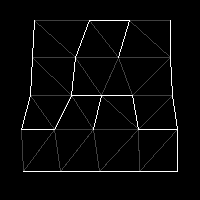

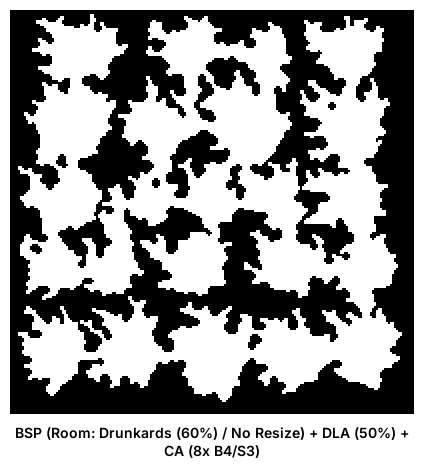

In [ ]:
render(
    chain(
        generate_rooms(
            room_bsp(count=30, spacing=10, min_width=20,
                     min_height=20, resize=False),
            maze_prims(),
            tunnel_simple(),
            generate_drunkard(ratio=0.45, max_steps=50,
                              max_walkers=1000, brush=Brush(size=2)),
        ),
        generate_dla(ratio=0.45, brush=Brush(size=2)),
        generate_cellular_automata(rounds=8),
    ),
    title="BSP (Room: Drunkards (60%) / No Resize) + DLA (50%) + CA (8x B4/S3)",
    width=200,
    height=200
)
